In [1]:
import yaml

with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [2]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, scoped_session
import pandas as pd

# 假设你有一个运行着的PostgreSQL数据库，且已经启用了TimescaleDB扩展
DATABASE_URI = f'''postgresql+psycopg2://{config['db']['user']}:{config['db']['password']}@{config['db']['host']}:{config['db']['port']}/{config['db']['database']}'''

# 初始化引擎
engine = create_engine(DATABASE_URI)

# 创建一个作用域(session)scoped session
Session = scoped_session(sessionmaker(bind=engine))

symbol = 'BTCUSDT'

# 开启一个新的会话(session)
with Session() as session:
    # SQL查询
    query = f'''SELECT * FROM "{symbol}" ORDER BY time DESC LIMIT 200'''

    # 使用pandas的read_sql_query函数直接将SQL查询结果转换为DataFrame
    df = pd.read_sql_query(query, session.bind)

# 将time列转换为pandas datetime对象
df['time'] = pd.to_datetime(df['time'])

# 因为我们按照时间降序排序获取了数据，所以可能需要将其重新排序以保持时间升序
df = df.sort_values('time')

# 将time列设为索引
df.set_index('time', inplace=True)

df.columns = ['Open', 'Close', 'High', 'Low', 'Volume']

print(df)

                              Open    Close     High      Low    Volume
time                                                                   
2023-07-08 21:30:00+00:00  30180.1  30173.0  30184.7  30153.0  1553.637
2023-07-08 22:00:00+00:00  30173.1  30156.1  30180.1  30151.2  1295.254
2023-07-08 22:30:00+00:00  30156.2  30212.0  30216.2  30156.1  1736.437
2023-07-08 23:00:00+00:00  30212.0  30247.0  30247.2  30211.9  2444.250
2023-07-08 23:30:00+00:00  30247.0  30269.3  30280.0  30199.9  4020.786
...                            ...      ...      ...      ...       ...
2023-07-12 23:00:00+00:00  30350.1  30359.6  30369.0  30341.7  2383.046
2023-07-12 23:30:00+00:00  30359.6  30368.9  30408.8  30352.9  4179.728
2023-07-13 00:00:00+00:00  30368.9  30379.1  30423.0  30356.0  3393.944
2023-07-13 00:30:00+00:00  30379.0  30343.9  30389.2  30326.0  3365.501
2023-07-13 01:00:00+00:00  30344.0  30331.6  30379.7  30330.0  1278.378

[200 rows x 5 columns]


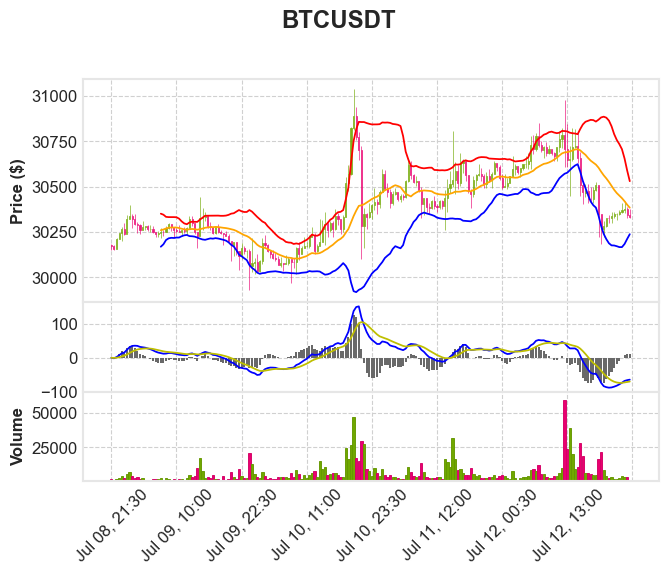

In [3]:
import mplfinance as mpf

# 计算 MACD
exp12 = df['Close'].ewm(span=12, adjust=False).mean()
exp26 = df['Close'].ewm(span=26, adjust=False).mean()
DIF = exp12 - exp26
DEA = DIF.ewm(span=9, adjust=False).mean()
MACD = 2 * (DIF - DEA)

# 计算布林带
mid_band = df['Close'].rolling(window=20).mean()
std_dev = df['Close'].rolling(window=20).std()
upper_band = mid_band + (std_dev*2)
lower_band = mid_band - (std_dev*2)

# 创建 MACD 和布林带的附图
ap_DIF = mpf.make_addplot(DIF, panel=1, color='b', secondary_y=False) # 将MACD设为面板0
ap_DEA = mpf.make_addplot(DEA, panel=1, color='y', secondary_y=False)
ap_MACD = mpf.make_addplot(MACD, panel=1, color='dimgray', secondary_y=False, type='bar')
ap_upper_band = mpf.make_addplot(upper_band, panel=0, color='red') # 将布林带设为面板2
ap_lower_band = mpf.make_addplot(lower_band, panel=0, color='blue')
ap_mid_band = mpf.make_addplot(mid_band, panel=0, color='orange')

# 绘制图表
mpf.plot(df, type='candle', style='binance', title=symbol, ylabel='Price ($)', volume=True, ylabel_lower='Volume', volume_panel=2, addplot=[ap_DIF, ap_DEA, ap_MACD, ap_upper_band, ap_lower_band, ap_mid_band])

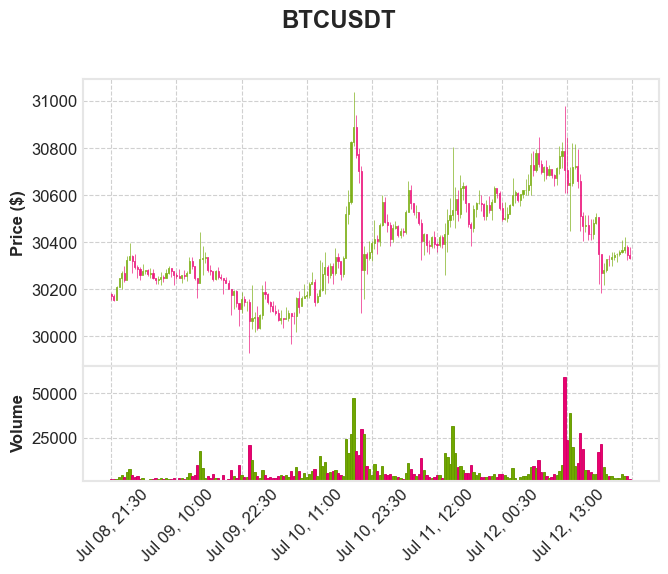

In [4]:
mpf.plot(df, type='candle', style='binance', title=symbol, ylabel='Price ($)', volume=True, ylabel_lower='Volume', volume_panel=1)